# Virtual Logit Matching (VIM) method

This notebook aims at evaluating the **VIM method**.

The method consists in analysing the projection of an input image in a feature subspace that contains the least information about in-distribution data. It is achieved by performing a PCA on the in-distribution dataset in the feature space. The norm of the projection of a new input data's feature representation onto the principal vectors explaining the least variance is then used for scoring.

This notebook quickly showcase VIM on MNIST vs Fashion MNIST.

**Reference**
[ViM: Out-Of-Distribution with Virtual-logit Matching](http://arxiv.org/abs/2203.10807), CVPR 2022.

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import pandas as pd
import matplotlib.pyplot as plt

from oodeel.methods import VIM
from oodeel.eval.metrics import bench_metrics
from oodeel.datasets import OODDataset
from oodeel.models.training_tools import train_convnet_classifier_tf

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")


Note that models are saved at *~/.oodeel/saved_models* by default. Change the following cell for a custom path.

In [ ]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
os.makedirs(model_path, exist_ok=True)

/!\ We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data with `_out` to avoid confusion with OOD detection which is the name of the task, and is therefore used to denote core classes such as `OODDataset` and `OODModel`.

In [3]:
oods_in = OODDataset('mnist', split="test")
oods_out = OODDataset('fashion_mnist', split="test")
oods_train = OODDataset('mnist', split="train")

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 64.00 GB
maxCacheSize: 3.99 GB



In [4]:
model_path_mnist = os.path.join(model_path, "mnist_model.h5")

try:
    model = tf.keras.models.load_model(model_path_mnist)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in#.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_tf(ds_train, **train_config) #ds_train is actually the train set of MNIST

## Using VIM by specifying the number of principal dimensions in the feature space 

In this variant, we explicitely select the number of principal vectors to exclude from our projection basis, computed using a PCA on 1000 samples from the training set. There will be `features_dim - princ_dims` vectors in the basis.

First, fit VIM to the model at hand.

In [5]:
princ_dims = 500
oodmodel = VIM(princ_dims=princ_dims)
oodmodel.fit(model, ds_train)

print(f"Number of princpal dimensions: {oodmodel._princ_dim}")

features_dim = oodmodel.feature_extractor.get_weights(-1)[0].shape[0]
print(f"Dimension of feature space:  {features_dim}")

Number of princpal dimensions: 500
Dimension of feature space:  1600


Then compute the scores for in-distribution and out-of-distribution data. Also display some visualizations.

auroc       0.987024
fpr95tpr    0.055400
Name: mnist-10-vs-fashion, dtype: float64


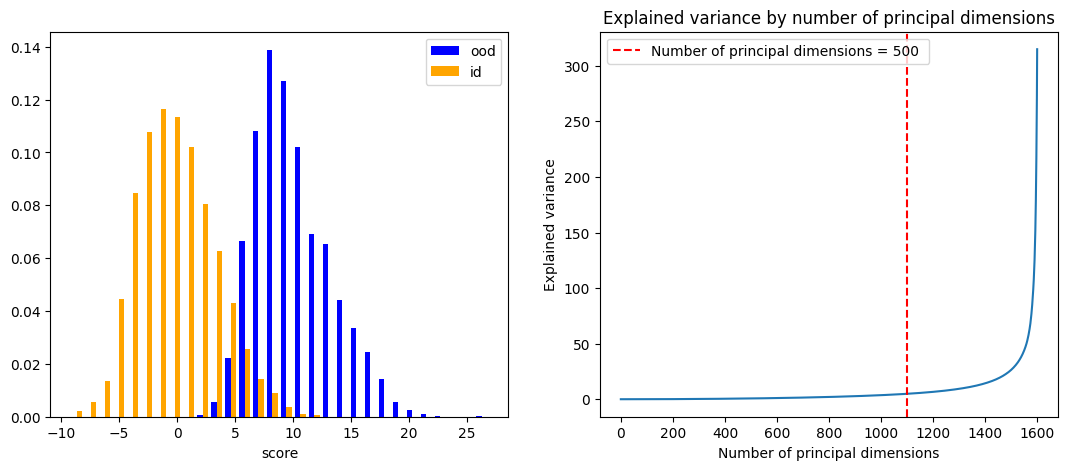

In [6]:
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr",], 
    )
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.subplot(122)
oodmodel.plot_spectrum()
plt.show()

## Using VIM by choosing the number of principal dims such that it explains the specified percentage of the variance. 

In this variant, we automatically select the number of principal vectors to exclude from our projection basis, computed using a PCA on 1000 samples from the training set. This number is computed based on the percentage of variance that we want to be explained by the excluded vectors. 

First, fit VIM to the model at hand.

In [7]:
princ_dims = 0.99
oodmodel = VIM(princ_dims=princ_dims)
oodmodel.fit(model, ds_train)

Then compute the scores for in-distribution and out-of-distribution data. Also display some visualizations.

auroc       0.988762
fpr95tpr    0.048100
Name: mnist-10-vs-fashion, dtype: float64


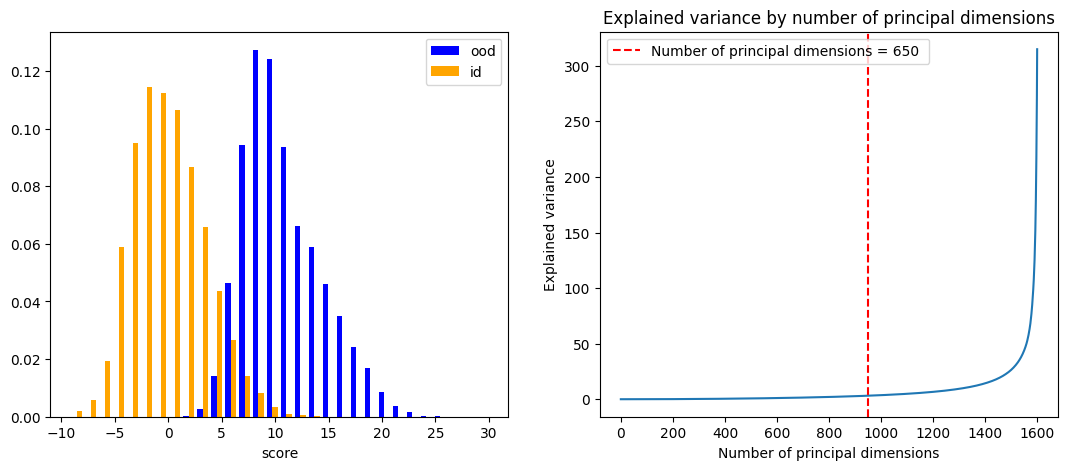

In [8]:
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr",], 
    )
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.subplot(122)
oodmodel.plot_spectrum()
plt.show()